In [1]:
import sys
!{sys.executable} -m pip install geopandas
!{sys.executable} -m pip install mplleaflet
!{sys.executable} -m pip install bs4
!{sys.executable} -m pip install geocoder
!{sys.executable} -m pip install geopy
!{sys.executable} -m pip install folium
!{sys.executable} -m pip install lxml
!{sys.executable} -m pip install pygeoj
!{sys.executable} -m pip install pyshp
!{sys.executable} -m pip install datetime
!{sys.executable} -m pip install seaborn
!{sys.executable} -m pip install --upgrade cython

# required package for timeseries
!{sys.executable} -m pip install statsmodels

# requiered package to run geopandas
!conda install -c conda-forge libspatialindex -y

# required packages for neighbourhood analysis
!{sys.executable} -m pip install geopandas
!{sys.executable} -m pip install descartes
!{sys.executable} -m pip install requests

# requiered packages for accessibility analysis
# Make sure Cython is upgraded FIRST!
!{sys.executable} -m pip install pandana

# requiered packages for modelling
!{sys.executable} -m pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is 

/bin/bash: conda: command not found
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
%matplotlib inline

# general
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Geographical analysis
import geopandas as gpf #libspatialindex nees to be installed first
import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import shapefile as shp
import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
import requests
import descartes

# accessibility analysis
import time
from pandana.loaders import osm
from pandana.loaders import pandash5

# modelling
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn import metrics
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score

#Hide warnings
import warnings
warnings.filterwarnings('ignore')

# Set plot preference
plt.style.use(style='ggplot')
plt.rcParams['figure.figsize'] = (10, 6)

print('Libraries imported.')

Libraries imported.


In [3]:
data = pd.read_csv('group_1_2_Amsterdam.csv')
print(f"The dataset contains {len(data)} Airbnb listings")
pd.set_option('display.max_columns', len(data.columns)) # To view all columns
pd.set_option('display.max_rows', 100)
data.head(3)

The dataset contains 3000 Airbnb listings


,name,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,room_type,accommodates,bedrooms,beds,price,minimum_nights,maximum_nights,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,reviews_per_month,days_as_host,city
0,"Amsterdam townhouse + sauna, 165m2",2016-03-03,within a few hours,100.0,NaN,f,1.0,1.0,t,t,Entire home/apt,6,3.0,7.0,636.0,2,1125,271,3,0,0,5.00,5.00,5.00,5.00,5.00,4.67,5.00,f,1,0.06,2094.0,Amsterdam
1,lovely apartment Amsterdam West,2012-05-13,within a few hours,67.0,43.0,f,1.0,1.0,t,t,Entire home/apt,4,2.0,2.0,250.0,2,30,23,22,6,0,4.86,4.91,4.82,4.95,4.91,4.86,4.59,f,1,0.54,3484.0,Amsterdam
2,Light apartment with garden;ten min to Leidsep...,2016-09-07,NaN,NaN,NaN,f,0.0,0.0,t,f,Entire home/apt,2,1.0,1.0,140.0,2,20,91,12,0,0,5.00,5.00,5.00,4.91,5.00,4.73,4.73,f,1,0.29,1906.0,Amsterdam


In [4]:
cols_drop = ['host_response_time', 'name', 'host_acceptance_rate', 'host_total_listings_count', 'city']
df = data.drop(cols_drop, axis=1)

In [5]:
df.head(3)

,host_since,host_response_rate,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,room_type,accommodates,bedrooms,beds,price,minimum_nights,maximum_nights,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,reviews_per_month,days_as_host
0,2016-03-03,100.0,f,1.0,t,t,Entire home/apt,6,3.0,7.0,636.0,2,1125,271,3,0,0,5.00,5.00,5.00,5.00,5.00,4.67,5.00,f,1,0.06,2094.0
1,2012-05-13,67.0,f,1.0,t,t,Entire home/apt,4,2.0,2.0,250.0,2,30,23,22,6,0,4.86,4.91,4.82,4.95,4.91,4.86,4.59,f,1,0.54,3484.0
2,2016-09-07,NaN,f,0.0,t,f,Entire home/apt,2,1.0,1.0,140.0,2,20,91,12,0,0,5.00,5.00,5.00,4.91,5.00,4.73,4.73,f,1,0.29,1906.0


In [6]:
df.isna().sum()

host_since                          1
host_response_rate                994
host_is_superhost                   1
host_listings_count                 1
host_has_profile_pic                1
host_identity_verified              1
room_type                           0
accommodates                        0
bedrooms                          188
beds                              141
price                               4
minimum_nights                      0
maximum_nights                      0
availability_365                    0
number_of_reviews                   0
number_of_reviews_ltm               0
number_of_reviews_l30d              0
review_scores_rating              260
review_scores_accuracy            271
review_scores_cleanliness         271
review_scores_checkin             271
review_scores_communication       271
review_scores_location            271
review_scores_value               271
instant_bookable                    0
calculated_host_listings_count      0
reviews_per_

In [7]:
df.insert(0, 'id', range(1, 1 + len(df)))
df

,id,host_since,host_response_rate,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,room_type,accommodates,bedrooms,beds,price,minimum_nights,maximum_nights,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,reviews_per_month,days_as_host
0,1,2016-03-03,100.0,f,1.0,t,t,Entire home/apt,6,3.0,7.0,636.0,2,1125,271,3,0,0,5.00,5.00,5.00,5.00,5.00,4.67,5.00,f,1,0.06,2094.0
1,2,2012-05-13,67.0,f,1.0,t,t,Entire home/apt,4,2.0,2.0,250.0,2,30,23,22,6,0,4.86,4.91,4.82,4.95,4.91,4.86,4.59,f,1,0.54,3484.0
2,3,2016-09-07,NaN,f,0.0,t,f,Entire home/apt,2,1.0,1.0,140.0,2,20,91,12,0,0,5.00,5.00,5.00,4.91,5.00,4.73,4.73,f,1,0.29,1906.0
3,4,2014-04-30,100.0,f,1.0,t,f,Entire home/apt,3,3.0,4.0,200.0,4,1125,34,11,3,0,4.91,5.00,4.91,5.00,5.00,4.73,4.91,f,1,0.12,2767.0
4,5,2017-07-03,96.0,f,0.0,t,t,Private room,2,1.0,2.0,71.0,2,1125,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,t,11,NaN,1607.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,2996,2016-07-20,100.0,f,1.0,t,t,Entire home/apt,2,1.0,1.0,165.0,4,12,0,2,2,0,5.00,5.00,5.00,5.00,5.00,5.00,5.00,f,1,0.54,1955.0
2996,2997,2016-01-01,100.0,t,2.0,t,t,Private room,2,1.0,1.0,68.0,1,1125,159,11,9,4,5.00,5.00,4.91,5.00,5.00,4.82,4.82,t,2,0.50,2156.0
2997,2998,2018-10-03,91.0,f,6.0,t,t,Entire home/apt,4,1.0,2.0,230.0,1,1125,349,180,164,10,4.66,4.62,4.72,4.84,4.72,4.41,4.43,t,6,11.54,1150.0
2998,2999,2015-10-02,100.0,t,1.0,t,t,Entire home/apt,4,2.0,3.0,200.0,2,1125,32,81,1,1,4.91,4.98,4.98,4.99,4.98,4.64,4.70,f,1,1.11,2247.0


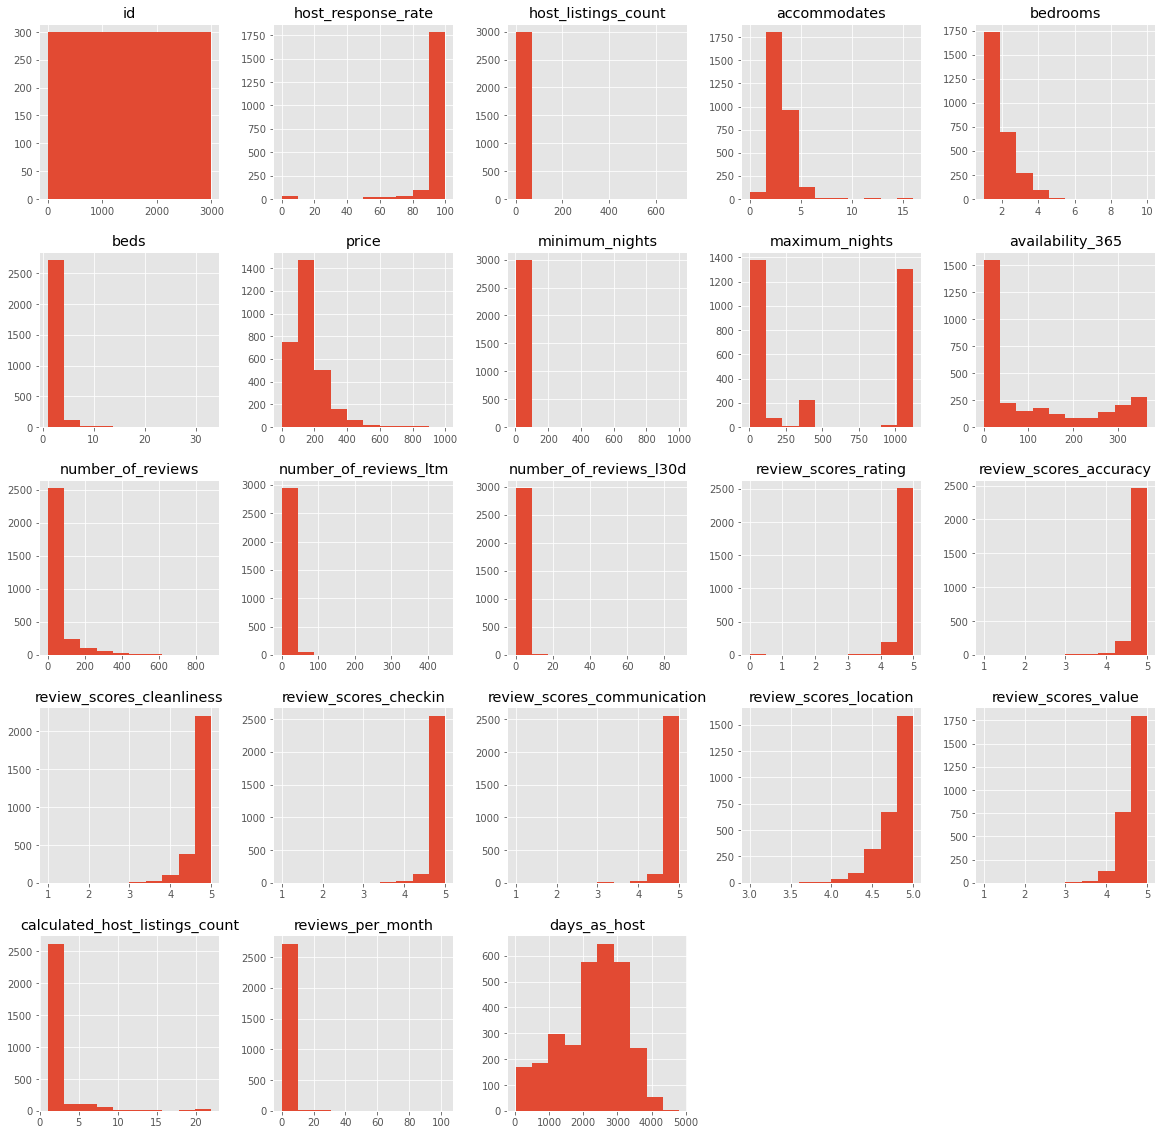

In [8]:
df.hist(figsize=(20,20));

In [9]:
df.room_type.value_counts()

Entire home/apt    1996
Private room        946
Hotel room           47
Shared room          11
Name: room_type, dtype: int64

In [10]:
df.room_type.replace({
    'Entire home/apt': 'Apartment' 
    }, inplace=True)

In [11]:
for col in ['bedrooms', 'beds']:
    df[col].fillna(df[col].median(), inplace=True)

In [12]:
df.price.astype('Int64')

0       636
1       250
2       140
3       200
4        71
       ... 
2995    165
2996     68
2997    230
2998    200
2999     41
Name: price, Length: 3000, dtype: Int64

In [13]:
df.bedrooms.astype('Int64')

0       3
1       2
2       1
3       3
4       1
       ..
2995    1
2996    1
2997    1
2998    2
2999    1
Name: bedrooms, Length: 3000, dtype: Int64

In [14]:
df.beds.astype('Int64')

0       7
1       2
2       1
3       4
4       2
       ..
2995    1
2996    1
2997    2
2998    3
2999    4
Name: beds, Length: 3000, dtype: Int64

In [15]:
df.days_as_host.astype('Int64')

0       2094
1       3484
2       1906
3       2767
4       1607
        ... 
2995    1955
2996    2156
2997    1150
2998    2247
2999     400
Name: days_as_host, Length: 3000, dtype: Int64

In [16]:
print(f"Null values in 'review_scores_rating': {round(100*df.review_scores_rating .isna().sum()/len(df),1)}%")

Null values in 'review_scores_rating': 8.7%


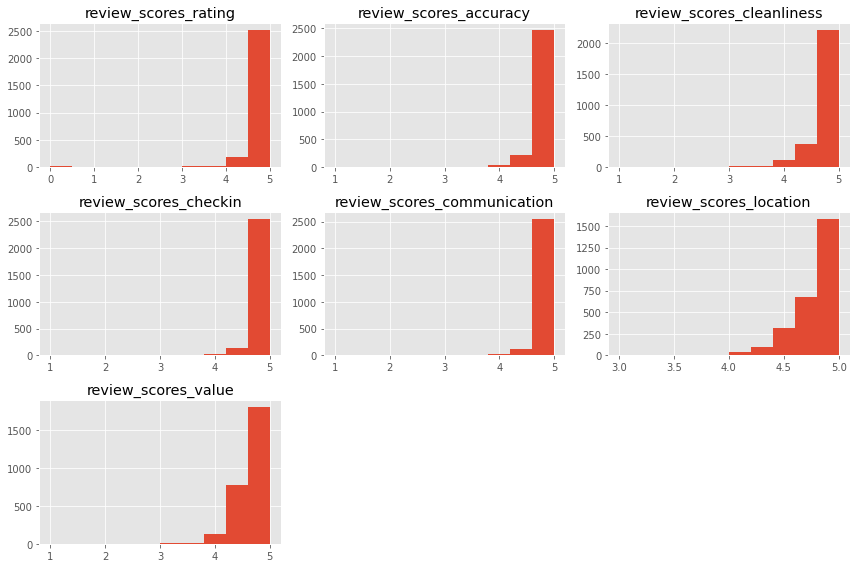

In [17]:
variables_to_plot = list(df.columns[df.columns.str.startswith("review_scores") == True])
fig = plt.figure(figsize=(12,8))
for i, var_name in enumerate(variables_to_plot):
    ax = fig.add_subplot(3,3,i+1)
    df[var_name].hist(bins=10,ax=ax)
    ax.set_title(var_name)
fig.tight_layout()
plt.show()

In [18]:
def bin_column(col, bins, labels, na_label='unknown'):
    """
    Takes in a column name, bin cut points and labels, replaces the original column with a
    binned version, and replaces nulls (with 'unknown' if unspecified).
    """
    df[col] = pd.cut(df[col], bins=bins, labels=labels, include_lowest=True)
    df[col] = df[col].astype('str')
    df[col].fillna(na_label, inplace=True)

In [47]:
df.host_since = pd.to_datetime(df.host_since) 
df.host_since

0      2016-03-03
1      2012-05-13
2      2016-09-07
3      2014-04-30
4      2017-07-03
          ...    
2995   2016-07-20
2996   2016-01-01
2997   2018-10-03
2998   2015-10-02
2999   2020-10-22
Name: host_since, Length: 3000, dtype: datetime64[ns]

In [52]:
# Converting to datetime
df.host_since = pd.to_datetime(df.host_since) 

# Calculating the number of days
df['host_days_active'] = (datetime(2021, 12, 1) - df.host_since).astype('timedelta64[D]').values.dtype

# Printing mean and median
print("Mean days as host:", round(df['host_days_active'].mean(),0))
print("Median days as host:", df['host_days_active'].median())

# Replacing null values with the median
df.host_days_active.fillna(df.host_days_active.median(), inplace=True)



TypeError: 'module' object is not callable

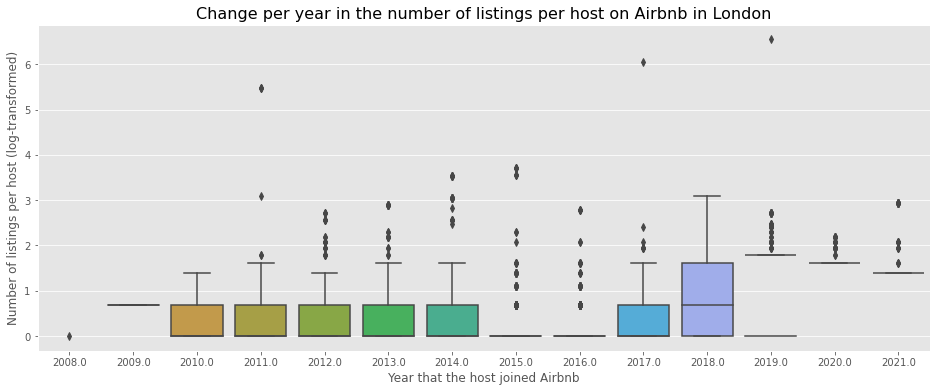

In [20]:
plt.figure(figsize=(16,6))
sns.boxplot(df.host_since.dt.year, np.log(df.host_listings_count))
plt.xlabel('Year that the host joined Airbnb', fontsize=12)
plt.ylabel('Number of listings per host (log-transformed)', fontsize=12)
plt.title('Change per year in the number of listings per host on Airbnb in London', fontsize=16)
plt.show()

In [21]:
print(f"Of the Airbnb hosts that are still listing on the site, the first joined on {min(df.host_since).strftime('%d %B %Y')}, and the most recent joined on {max(df.host_since).strftime('%d %B %Y')}.")

Of the Airbnb hosts that are still listing on the site, the first joined on 24 September 2008, and the most recent joined on 02 November 2021.


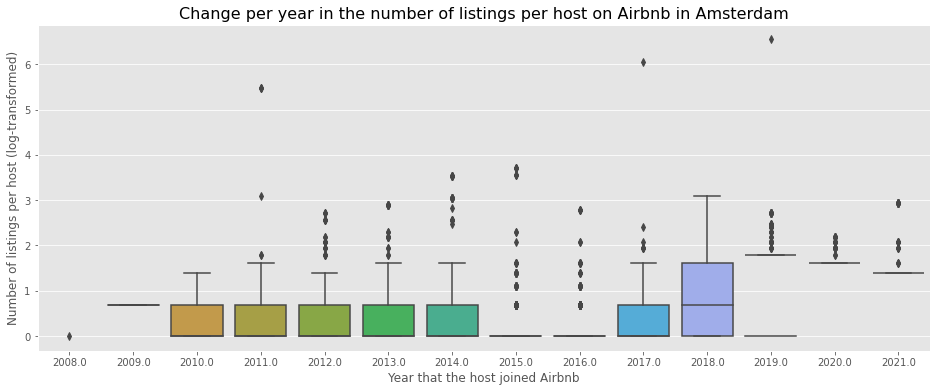

In [22]:
plt.figure(figsize=(16,6))
sns.boxplot(df.host_since.dt.year, np.log(df.host_listings_count))
plt.xlabel('Year that the host joined Airbnb', fontsize=12)
plt.ylabel('Number of listings per host (log-transformed)', fontsize=12)
plt.title('Change per year in the number of listings per host on Airbnb in Amsterdam', fontsize=16)
plt.show()

In [23]:
print("Average number of listings per host per year on Airbnb in Amsterdam:")
print(round(df.set_index('host_since').host_listings_count.resample('YS').mean(),2))

Average number of listings per host per year on Airbnb in Amsterdam:
host_since
2008-01-01    0.50
2009-01-01    2.00
2010-01-01    1.55
2011-01-01    8.92
2012-01-01    1.86
2013-01-01    1.88
2014-01-01    2.19
2015-01-01    1.86
2016-01-01    1.37
2017-01-01    3.94
2018-01-01    4.18
2019-01-01    6.85
2020-01-01    2.42
2021-01-01    3.51
Name: host_listings_count, dtype: float64


In [24]:
df.sort_values('host_listings_count').drop_duplicates('host_listings_count',keep='last').tail(10)[['host_since', 'host_listings_count']]

,host_since,host_listings_count
1028,2018-07-20,20.0
1801,2014-04-22,21.0
2731,2018-03-13,22.0
2082,2014-09-10,34.0
978,2015-09-14,35.0
2046,2015-10-16,41.0
2367,2011-04-18,238.0
212,2017-03-22,429.0
2846,2019-06-21,700.0
1198,NaT,NaN


In [25]:
df.describe()

,id,host_response_rate,host_listings_count,accommodates,bedrooms,beds,price,minimum_nights,maximum_nights,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,reviews_per_month,days_as_host
count,3000.000000,2006.000000,2999.000000,3000.000000,3000.000000,3000.000000,2996.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,2740.000000,2729.000000,2729.000000,2729.000000,2729.000000,2729.000000,2729.000000,3000.000000,2740.000000,2999.000000
mean,1500.500000,95.081256,2.793598,2.939000,1.534333,1.926000,166.234312,3.474667,537.870000,103.322000,49.364000,5.384667,0.969000,4.785281,4.837263,4.757534,4.877647,4.884833,4.783170,4.641898,2.172333,1.459741,2285.675225
std,866.169729,15.094643,17.172935,1.409707,0.861628,1.602305,105.275303,19.155374,526.623944,126.649462,86.780465,15.712956,2.674027,0.388715,0.231705,0.307937,0.221157,0.228486,0.227798,0.284650,3.129201,3.064017,938.127584
min,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,3.000000,1.000000,1.000000,0.010000,24.000000
25%,750.750000,100.000000,1.000000,2.000000,1.000000,1.000000,99.000000,2.000000,25.000000,0.000000,5.000000,0.000000,0.000000,4.720000,4.780000,4.670000,4.850000,4.870000,4.670000,4.530000,1.000000,0.300000,1672.500000
50%,1500.500000,100.000000,1.000000,2.000000,1.000000,1.000000,142.000000,2.000000,365.000000,32.000000,17.000000,1.000000,0.000000,4.870000,4.900000,4.850000,4.940000,4.960000,4.830000,4.680000,1.000000,0.670000,2433.000000
75%,2250.250000,100.000000,2.000000,4.000000,2.000000,2.000000,200.000000,3.000000,1125.000000,204.000000,50.000000,5.000000,1.000000,4.980000,5.000000,4.970000,5.000000,5.000000,4.970000,4.800000,2.000000,1.660000,2995.000000
max,3000.000000,100.000000,700.000000,16.000000,10.000000,33.000000,999.000000,1001.000000,1125.000000,365.000000,885.000000,448.000000,88.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,22.000000,102.600000,4811.000000


In [26]:
print(f"Nightly advertised prices range from £{min(df.price)} to £{max(df.price)}.")

Nightly advertised prices range from £0.0 to £999.0.


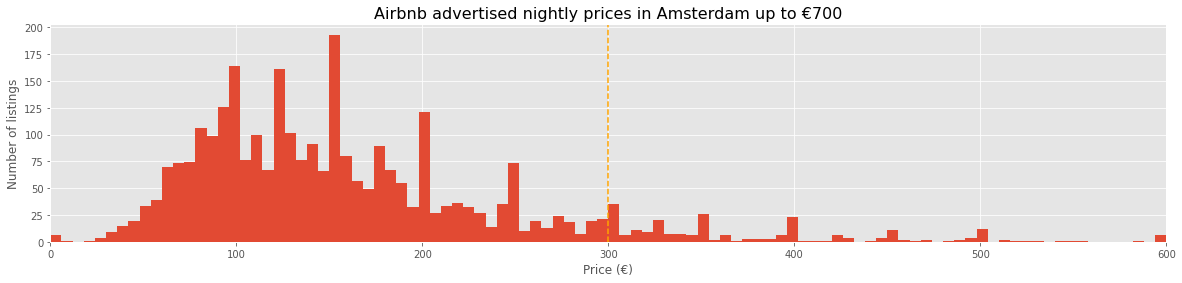

In [27]:
# Distribution of prices from €0 to €600
plt.figure(figsize=(20,4))
df.price.hist(bins=100, range=(0,600))
plt.margins(x=0)
plt.axvline(300, color='orange', linestyle='--')
plt.title("Airbnb advertised nightly prices in Amsterdam up to €700", fontsize=16)
plt.xlabel("Price (€)")
plt.ylabel("Number of listings")
plt.show()

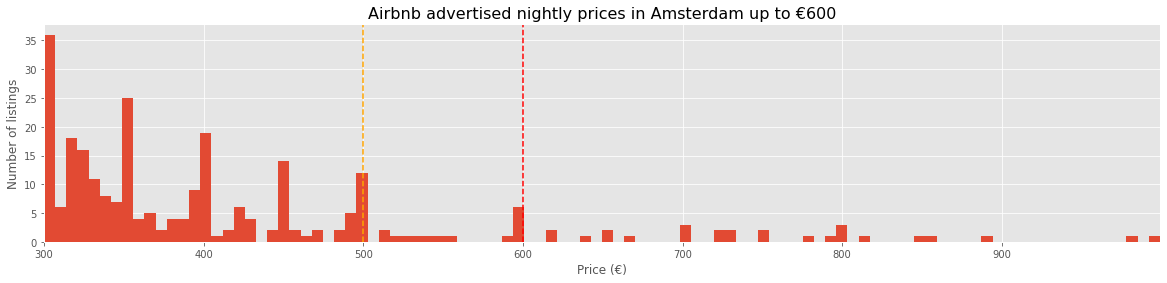

In [28]:
# Distribution of prices from €200 upwards
plt.figure(figsize=(20,4))
df.price.hist(bins=100, range=(300, max(df.price)))
plt.margins(x=0)
plt.axvline(500, color='orange', linestyle='--')
plt.axvline(600, color='red', linestyle='--')
plt.title("Airbnb advertised nightly prices in Amsterdam up to €600", fontsize=16)
plt.xlabel("Price (€)")
plt.ylabel("Number of listings")
plt.show()

In [29]:
# Replacing values under £10 with £10
df.loc[df.price <= 30, 'price'] = 30

# Replacing values over £1000 with £1000
df.loc[df.price >= 600, 'price'] = 600

In [30]:
print("Median number of listings per host:", int(df.host_listings_count.median()))
print("Mean number of listings per host:", int(round(df.host_listings_count.mean())))
print(f"{int(round(100*len(df[df.host_listings_count == 1])/len(df)))}% of listings are from hosts with one listing.")

Median number of listings per host: 1
Mean number of listings per host: 3
52% of listings are from hosts with one listing.


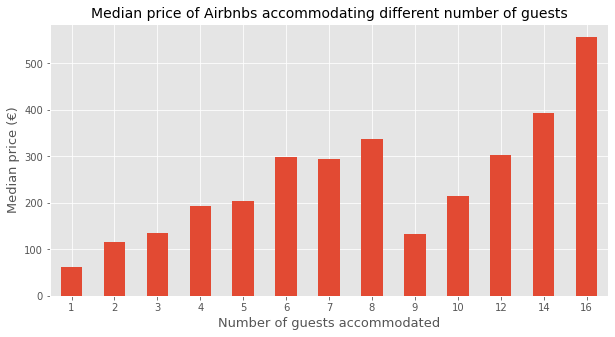

In [31]:
plt.figure(figsize=(10,5))
df.groupby('accommodates').price.median().plot(kind='bar')
plt.title('Median price of Airbnbs accommodating different number of guests', fontsize=14)
plt.xlabel('Number of guests accommodated', fontsize=13)
plt.ylabel('Median price (€)', fontsize=13)
plt.xticks(rotation=0)
plt.xlim(left=0.5)
plt.show()

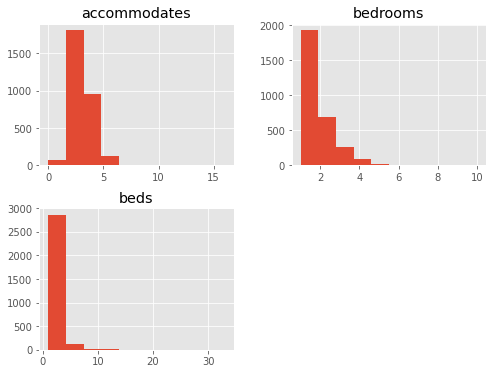

In [32]:
df[['accommodates', 'bedrooms', 'beds']].hist(figsize=(8,6));

In [33]:
def category_count_plot(col, figsize=(8,4)):
    """
    Plots a simple bar chart of the total count for each category in the column specified.
    A figure size can optionally be specified.
    """
    plt.figure(figsize=figsize)
    df[col].value_counts().plot(kind='bar')
    plt.title(col)
    plt.xticks(rotation=0)
    plt.show()

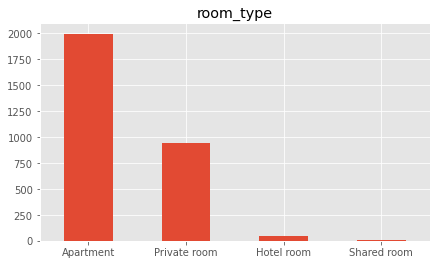

Apartment       0.665333
Private room    0.315333
Hotel room      0.015667
Shared room     0.003667
Name: room_type, dtype: float64


In [34]:
for col in ['room_type']:
    category_count_plot(col, figsize=(7,4))
    print(df[col].value_counts(normalize=True))

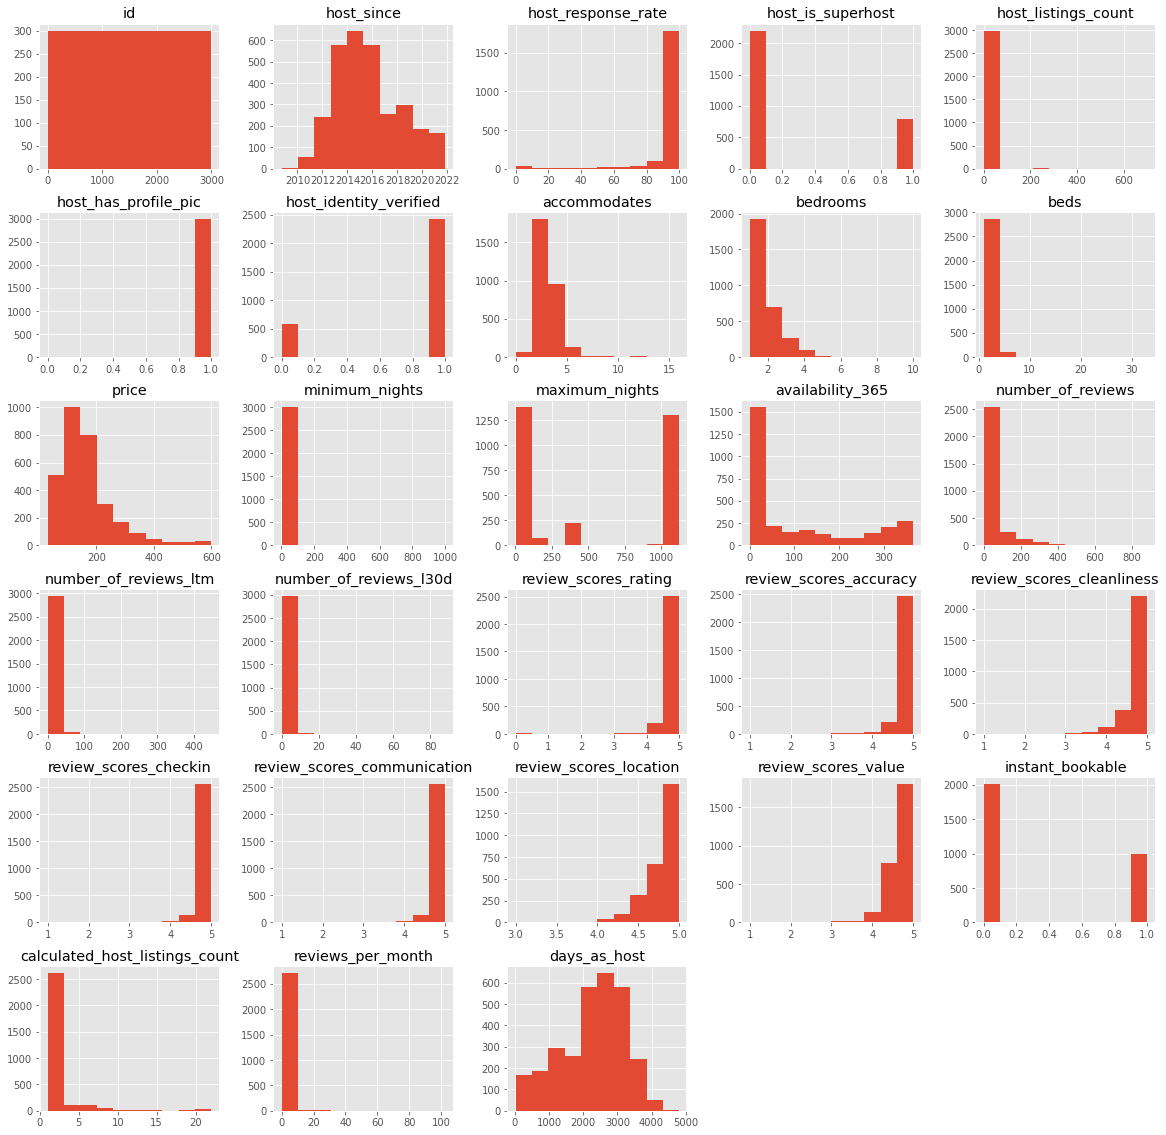

In [35]:
# Replacing columns with f/t with 0/1
df.replace({'f': 0, 't': 1}, inplace=True)

# Plotting the distribution of numerical and boolean categories
df.hist(figsize=(20,20));

In [36]:
def binary_count_and_price_plot(col, figsize=(8,3)):
    """
    Plots a simple bar chart of the counts of true and false categories in the column specified,
    next to a bar chart of the median price for each category.
    A figure size can optionally be specified.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle(col, fontsize=16, y=1)
    plt.subplots_adjust(top=0.80) # So that the suptitle does not overlap with the ax plot titles
    
    df.groupby(col).size().plot(kind='bar', ax=ax1, color=['firebrick', 'seagreen'])
    ax1.set_xticklabels(labels=['false', 'true'], rotation=0)
    ax1.set_title('Category count')
    ax1.set_xlabel('')
    
    df.groupby(col).price.median().plot(kind='bar', ax=ax2, color=['firebrick', 'seagreen'])
    ax2.set_xticklabels(labels=['false', 'true'], rotation=0)
    ax2.set_title('Median price (£)')
    ax2.set_xlabel('')
    
    plt.show()

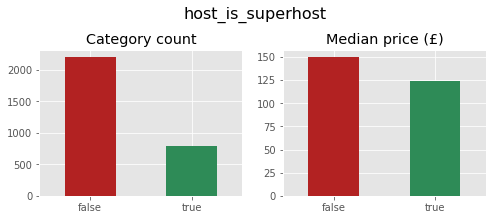

0.0    0.734245
1.0    0.265755
Name: host_is_superhost, dtype: float64


In [37]:
binary_count_and_price_plot('host_is_superhost')
print(df.host_is_superhost.value_counts(normalize=True))

In [38]:
df.host_identity_verified.value_counts(normalize=True)

1.0    0.80927
0.0    0.19073
Name: host_identity_verified, dtype: float64

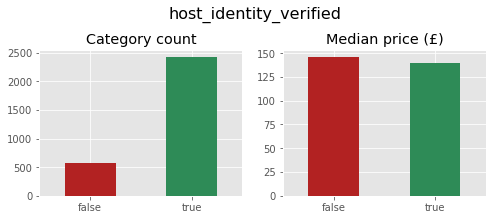

In [39]:
binary_count_and_price_plot('host_identity_verified')

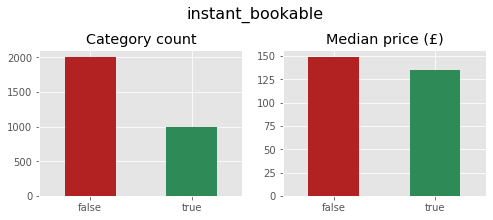

0    0.669
1    0.331
Name: instant_bookable, dtype: float64


In [40]:
binary_count_and_price_plot('instant_bookable')
print(df.instant_bookable.value_counts(normalize=True))

In [41]:
transformed_df = pd.get_dummies(df)

In [42]:
def multi_collinearity_heatmap(df, figsize=(11,9)):
    
    """
    Creates a heatmap of correlations between features in the df. A figure size can optionally be set.
    """
    
    # Set the style of the visualization
    sns.set(style="white")

    # Create a covariance matrix
    corr = df.corr()

    # Generate a mask the size of our covariance matrix
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=figsize)

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmax=corr[corr != 1.0].max().max());

In [53]:
transformed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 32 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   id                              3000 non-null   int64         
 1   host_since                      2999 non-null   datetime64[ns]
 2   host_response_rate              2006 non-null   float64       
 3   host_is_superhost               2999 non-null   float64       
 4   host_listings_count             2999 non-null   float64       
 5   host_has_profile_pic            2999 non-null   float64       
 6   host_identity_verified          2999 non-null   float64       
 7   accommodates                    3000 non-null   float64       
 8   bedrooms                        3000 non-null   float64       
 9   beds                            3000 non-null   float64       
 10  price                           2996 non-null   float64       
 11  mini

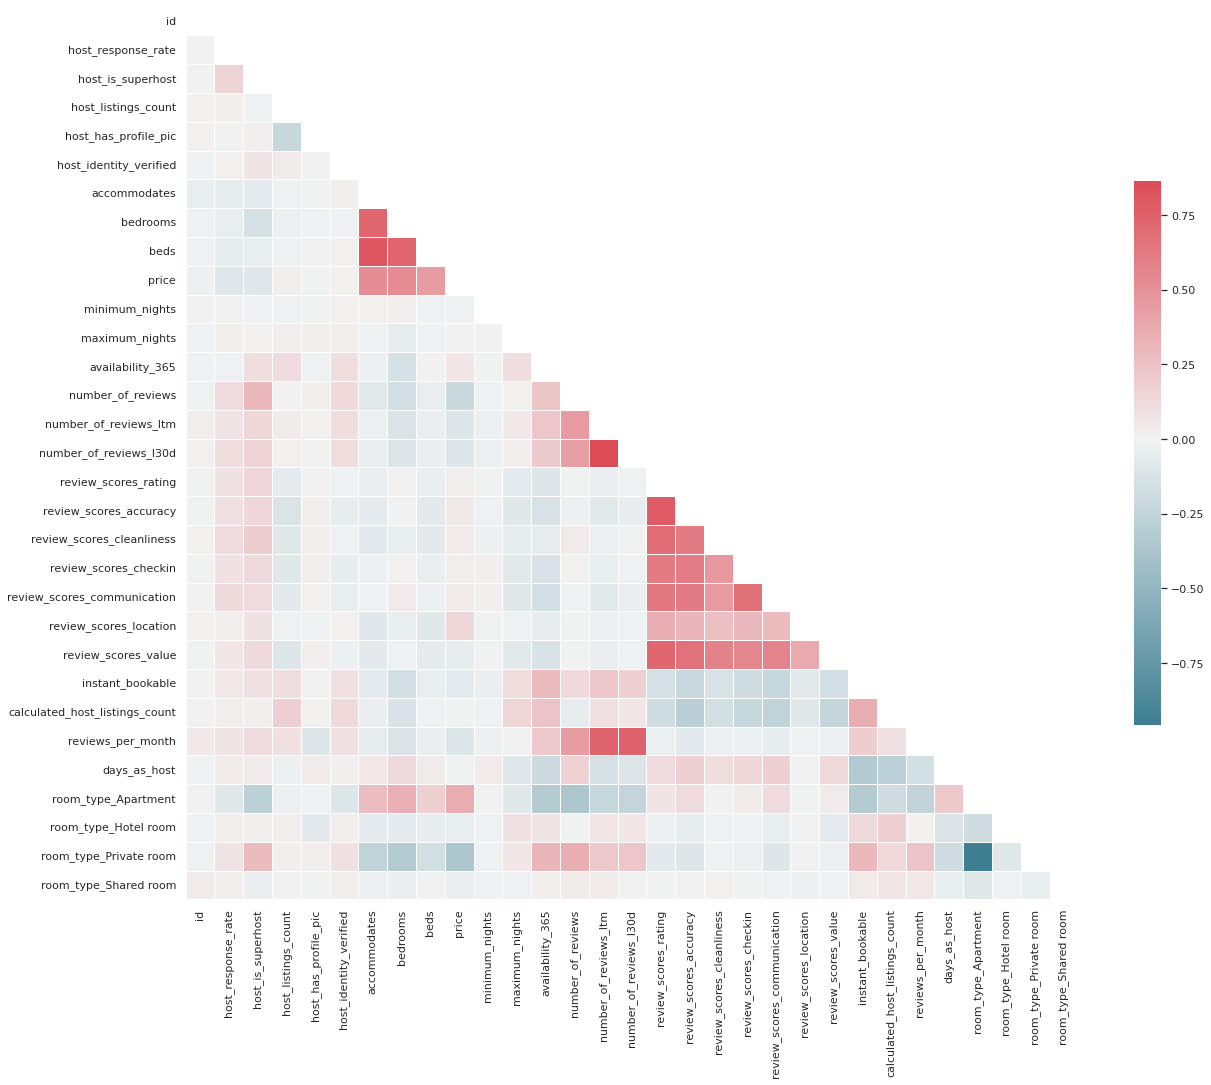

In [43]:
multi_collinearity_heatmap(transformed_df, figsize=(20,20))

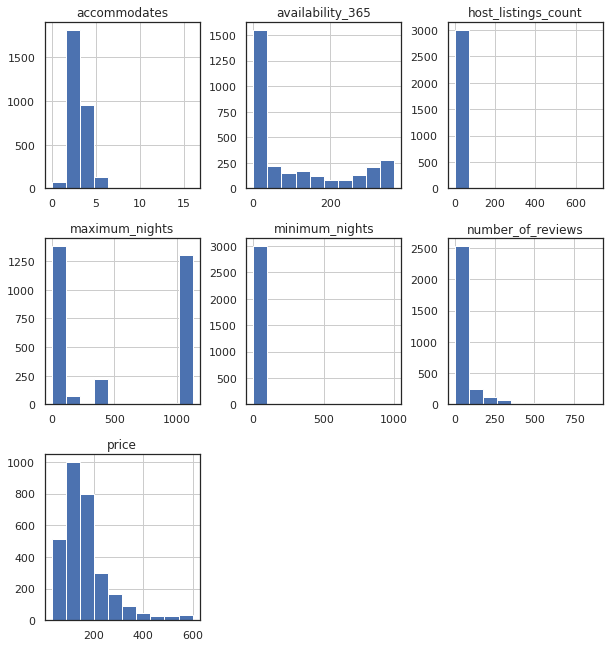

In [44]:
numerical_columns = ['accommodates', 'availability_365', 'host_listings_count', 'maximum_nights', 'minimum_nights', 'number_of_reviews', 'price']
transformed_df[numerical_columns].hist(figsize=(10,11));

In [50]:
#numerical_columns = [i for i in numerical_columns if i not in ['availability_90', 'host_days_active']] # Removing items not to be transformed

#for col in numerical_columns:
 #   transformed_df[col] = transformed_df[col].astype('float64').replace(0.0, 0.01) # Replacing 0s with 0.01
  #  transformed_df[col] = np.log(transformed_df[col])


#transformed_df[numerical_columns].hist(figsize=(10,11));

In [51]:
X = train_df.drop('price', axis = 1) # her we are droping the 'Price' feature as this is the target and 'X' is input features, the changes are not
# made inplace as we have not used 'inplace = True'

y = train_df['price'] # Output/Dependent variable

TypeError: The DType <class 'numpy.dtype[datetime64]'> could not be promoted by <class 'numpy.dtype[float64]'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtype[int64]'>, <class 'numpy.dtype[datetime64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[int64]'>, <class 'numpy.dtype[int64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[int64]'>, <class 'numpy.dtype[int64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>, <class 'numpy.dtype[uint8]'>)